# [Scene Recognition with Deep Learning](https://www.cc.gatech.edu/~hays/compvision/proj4/)
For this project we are going to focus on scene classification for 15 scene types with a state-of-the-art approach: deep learning. The task is also known as image classification. 

Basic learning objectives of this project:
1. Construct the fundamental pipeline for performing deep learning using PyTorch;
2. Understand the concepts behind different layers, optimizers, and learning schedules;
3. Experiment with different models and observe the performance.

The starter code is mostly initialized to 'placeholder' just so that the starter
code does not crash when run unmodified and you can get a preview of how
results are presented.

In [1]:
# flag to modify everything to run better on Colab; change it to true if you want to run on colab
use_colab = False

## Part 0: Setup for Colab
You can skip this part if you are not running your notebook on Colab.

### GPU Configuration

We'll set up GPU computation on Colab.

Click on Runtime $\rightarrow$ Change Runtime Type, and select "GPU" under hardware accelerator.

### Download Data

Download the data for training the network. It's exactly the same as that's been provided for you, but we'll fetch this from the cloud to keep uploads small

In [2]:
# uncomment for running on colab
# uncomment for running on colab
# !wget "https://faculty.cc.gatech.edu/~hays/compvision2021fall/projects/proj4_data.zip" --no-check-certificate -O data.zip && unzip -qq data.zip
# !rm ./data.zip

### Upload code and unit tests

Once you have finished your code, run `python ./zip_for_colab.py` and all the required files and tests will be written to `cv_proj4.zip`.

Click the folder icon on the left of the colab UI, and click on the upload button right below the "Files" heading. You should have done a similar process for Project 4.

Run the cell below once your upload completes to extract your uploaded files.

In [3]:
# uncomment for running on colab
# !unzip -qq cv_proj4.zip -d ./
# !mv -v ./src/vision ./
# !pip install -e .

### Preparation

Import the required functions:

In [188]:
import os

import torch

from vision.runner import Trainer, MultiLabelTrainer
from vision.optimizer import get_optimizer
from vision.simple_net import SimpleNet
from vision.simple_net_final import SimpleNetFinal
from vision.my_resnet import MyResNet18
from vision.multilabel_resnet import MultilabelResNet18
from vision.data_transforms import (
    get_fundamental_transforms,
    get_fundamental_normalization_transforms,
    get_fundamental_augmentation_transforms,
    get_all_transforms,
)
from vision.stats_helper import compute_mean_and_std
from vision.confusion_matrix import (
    generate_confusion_data,
    generate_confusion_matrix,
    plot_confusion_matrix,
    get_pred_images_for_target,
    generate_and_plot_confusion_matrix,
    generate_and_plot_accuracy_table,
)
from vision.dl_utils import save_trained_model_weights

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
from tests.utils import verify
from tests.test_stats_helper import test_mean_and_variance
from tests.test_image_loader import (
    test_dataset_length,
    test_unique_vals,
    test_class_values,
    test_load_img_from_path,
    test_multilabel_dataset_length,
    test_multilabel_unique_vals,
)
from tests.test_data_transforms import (
    test_fundamental_transforms,
    test_data_augmentation_transforms,
    test_data_augmentation_with_normalization_transforms,
)
from tests.test_dl_utils import (
    test_compute_accuracy,
    test_compute_loss,
    test_compute_multilabel_accuracy,
)
from tests.test_simple_net import test_simple_net
from tests.test_simple_net_final import test_simple_net_final
from tests.test_my_resnet import test_my_resnet
from tests.test_multilabel_resnet import test_multilabel_resnet
from tests.test_confusion_matrix import (
    test_generate_confusion_matrix,
    test_generate_confusion_matrix_normalized,
)

In [190]:
is_cuda = True
is_cuda = (
    is_cuda and torch.cuda.is_available()
)  # will turn off cuda if the machine doesnt have a GPU

In [191]:
data_path = "./data/" if not use_colab else "./data/"
model_path = "../model_checkpoints/" if not use_colab else "./model_checkpoints/"

## Part 1: SimpleNet
To train a network in PyTorch, we need 4 components:
1. **Dataset** - an object which can load the data and labels given an index.
2. **Model** - an object that contains the network architecture definition.
3. **Loss function** - a function that measures how far the network output is from the ground truth label.
4. **Optimizer** - an object that optimizes the network parameters to reduce the loss value.

### Part 1.1: Datasets
Now let's create the **Datasets** object to be used later. Remember back in Project 1, we have initialized such a class to load 5 images? Here the task is similar: we have to load each image as well as it's classification label. The key idea is to store the paths to all the images in your dataset, and then be able to provide the image file path and its ground truth class id when given the index of a data example.

We will map the scene names (text) into indices 0 to 14 in the image loader. You can choose any mapping you want but once fixed, it has to be consistent throughout this notebook.

**TODO 1:** complete the `image_loader.py`

In [192]:
inp_size = (64, 64)
print("Testing your image loader (length):", verify(test_dataset_length))
print("Testing your image loader (values):", verify(test_unique_vals))
print("Testing your image loader (classes):", verify(test_class_values))
print("Testing your image loader (paths):", verify(test_load_img_from_path))

Testing your image loader (length): "Correct"
Testing your image loader (values): "Correct"
Testing your image loader (classes): "Correct"
Testing your image loader (paths): "Correct"


### Data transforms
**TODO 2:** complete the function `get_fundamental_transforms()` in `data_transforms.py` to compile the following fundamental transforms:
1. Resize the input image to the desired shape;
2. Convert it to a tensor.

In [193]:
print("Testing your fundamental data transforms: ", verify(test_fundamental_transforms))

Testing your fundamental data transforms:  "Correct"


### Part 1.2: Model
The data is ready! Now we are preparing to move to the actual core of deep learning: the architecture. To get you started in this part, simply define a **2-layer** model in the `simple_net.py`. Here by "2 layers" we mean **2 convolutional layers**, so you need to figure out the supporting utilities like ReLU, Max Pooling, and Fully Connected layers, and configure them with proper parameters to make the tensor flow.

You may refer to Figure 2 in proj4 handout for a sample network architecture (it's the architecture TAs used in their implementation and is sufficient to get you pass Part 1).

**TODO 3**: Do the following in ```simple_net.py```:
- ```self.conv_layers```
- ```self.fc_layers```
- ```forward()```

Leave the ```self.loss_criterion = None``` for now.

In [194]:
print("Testing your SimpleNet architecture: ", verify(test_simple_net))

Testing your SimpleNet architecture:  "Correct"


In [195]:
simple_model = SimpleNet()

### Loss function
When defining your model architecture, also initialize the `loss_criterion` variable there. Remeber this is multi-class classification problem, and choose the [appropriate loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) might be useful here.

**TODO 4:** Assign a loss function to ```self.loss_criterion``` in ```simple_net.py```.

In [196]:
print(simple_model)

SimpleNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=500, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=15, bias=True)
  )
  (layer1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (layer2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (layer3): ReLU()
  (layer4): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (layer5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (layer6): ReLU()
  (layer7): Flatten(start_dim=1, end_dim=-1)
  (layer8): Linear(in_features=500, out_features=100, bias=True

### Optimizer
**TODO 5:** **initialize the following cell with proper values for learning rate and weight decay** (you will need to come back and tune these values for better performance once the trainer section is done)

In [197]:
# TODO: add a decent initial setting and tune from there. The values are intentionally bad.
optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-5}

**TODO 6:** complete the ```get_optimizer()``` function in ```optimizer.py```. The helper function accepts three basic configurations as defined below. Any other configuration is optional. *SGD* optimizer type should be supported, anything else is optional.

In [201]:
optimizer = get_optimizer(simple_model, optimizer_config)

conv_layers.0.weight : torch.Size([10, 1, 5, 5])
conv_layers.0.bias : torch.Size([10])
conv_layers.3.weight : torch.Size([20, 10, 5, 5])
conv_layers.3.bias : torch.Size([20])
fc_layers.1.weight : torch.Size([100, 500])
fc_layers.1.bias : torch.Size([100])
fc_layers.2.weight : torch.Size([15, 100])
fc_layers.2.bias : torch.Size([15])


### Part 1.3: Trainer

**TODO 7:** Next we define the trainer for the model; to start, we will need to do the following in ```dl_utils.py```:
- ```compute_loss()```: use the model's loss criterion and compute the corresponding loss between the model output and the ground-truth labels.
- ```compute_accuracy()```: compute the classification accuracy given the prediction logits and the ground-truth labels.

In [15]:
print("Testing your trainer (loss values): ", verify(test_compute_loss))
print("Testing your trainer (accuracy computation): ", verify(test_compute_accuracy))

Testing your trainer (loss values):  "Correct"
Testing your trainer (accuracy computation):  "Correct"


Then pass in the model, optimizer, transforms for both the training and testing datasets into the trainer, and proceed to the next cell to train it. If you have implemented everything correctly, you should be seeing a decreasing loss value.

**Note** in this project, we will be using the test set as the validation set (i.e. using it to guide our decisions about models and hyperparameters while training. In actual practise, you would not interact with the test set until reporting the final results.

**Note** that your CPU should be sufficient to handle the training process for all networks in this project, and the following training cells will take less than 5 minutes; you may also want to decrease the value for `num_epochs` and quickly experiment with your parameters. The default value of **30** is good enough to get you around the threshold for Part 1, and you are free to increase it a bit and adjust other parameters in this part.

In [185]:
# re-init the model so that the weights are all random
simple_model_base = SimpleNet()
optimizer = get_optimizer(simple_model_base, optimizer_config)

trainer = Trainer(
    data_dir=data_path,
    model=simple_model_base,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "simple_net"),
    train_data_transforms=get_fundamental_transforms(inp_size),
    val_data_transforms=get_fundamental_transforms(inp_size),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
)

AttributeError: 'generator' object has no attribute 'shape'

In [17]:
%%time
trainer.run_training_loop(num_epochs=30)

Epoch:1 Train Loss:0.0809 Val Loss: 0.0755 Train Accuracy: 0.1350 Validation Accuracy: 0.2227
Epoch:2 Train Loss:0.0678 Val Loss: 0.0671 Train Accuracy: 0.2764 Validation Accuracy: 0.2953
Epoch:3 Train Loss:0.0630 Val Loss: 0.0640 Train Accuracy: 0.3152 Validation Accuracy: 0.2973
Epoch:4 Train Loss:0.0610 Val Loss: 0.0630 Train Accuracy: 0.3451 Validation Accuracy: 0.3007
Epoch:5 Train Loss:0.0590 Val Loss: 0.0627 Train Accuracy: 0.3705 Validation Accuracy: 0.3293
Epoch:6 Train Loss:0.0567 Val Loss: 0.0617 Train Accuracy: 0.4060 Validation Accuracy: 0.3373
Epoch:7 Train Loss:0.0550 Val Loss: 0.0633 Train Accuracy: 0.4060 Validation Accuracy: 0.3240
Epoch:8 Train Loss:0.0533 Val Loss: 0.0565 Train Accuracy: 0.4422 Validation Accuracy: 0.4000
Epoch:9 Train Loss:0.0507 Val Loss: 0.0586 Train Accuracy: 0.4687 Validation Accuracy: 0.3740
Epoch:10 Train Loss:0.0507 Val Loss: 0.0544 Train Accuracy: 0.4647 Validation Accuracy: 0.4253
Epoch:11 Train Loss:0.0483 Val Loss: 0.0567 Train Accuracy:

After you have finished the training process, now plot out the loss and accuracy history. You can also check out the final accuracy for both training and testing data. Copy the accuracy plots and values onto the report, and answer the questions there. 

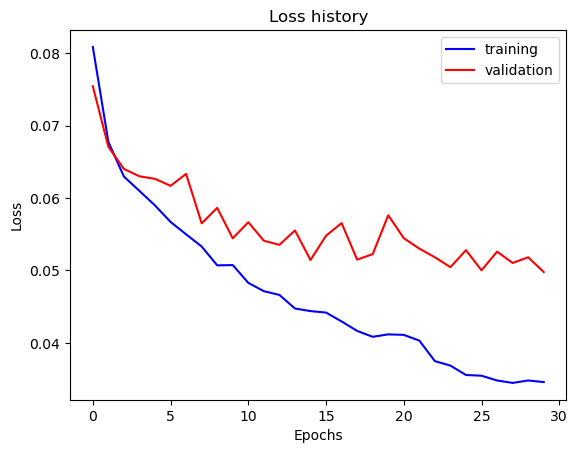

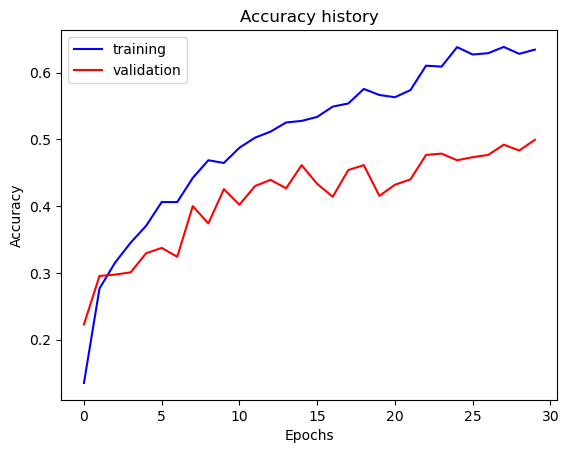

In [18]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [19]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.6345058626465662; Validation Accuracy = 0.49933333333333335


**TODO 8:** Obtain **45%** validation accuracy to receive full credit for Part 1. You can go back to TODO 5 to tune your parameters using the following tips:
1. If the loss decreases very slowly, try increasing the value of the lr (learning rate).
2. Initially keep the value of weight decay (L2-regularization) very low.
3. Try to first adjust lr in multiples of 3 initially. When you are close to reasonable performance, do a more granular adjustment.
4. If you want to increase the validation accuracy by a little bit, try increasing the weight_decay to prevent overfitting. Do not use tricks from Section 6 just yet.

### Save the model for your SimpleNet
Once you are satisfied with the performance of your trained model, you need to save it so that you can upload it to Gradescope along with the other models.

We'll save the model to the current directory. If you're running locally on your computer, this should be in the `vision` folder, which is the desired location for uploading to gradescope.

If you are running on Colab, make sure you download the trained `.pt` files that will be generated. This process is similar to that of Project 4.
- Click on the folder icon in the left hand side menu
- Select the 3 dots next to the `<out_name>.pt` file that is generated and click download
- Store the file in the `vision` folder.

In [20]:
save_trained_model_weights(simple_model_base, out_dir="./")

## Part 2: SimpleNet with additional modifications

In Part 1 we implemented a basic CNN, but it doesn’t perform very well.  Let’s try a few tricks to see if we canimprove our model performance. You can start by copying your `SimpleNet` architecture from `simple_net.py` into `SimpleNetFinal` class in `simple_net_final.py`.

**NOTE**: Before working on this part of the project, make sure to take a look at the report and write down your initial training and validation accuracy of your `SimpleNet` from the previous part. We will keep track of how these values change at each step of adding a few feature as we build up to `SimpleNetFinal`.

### Part 2.1: Problem 1 We don’t have enough training data. Let’s “jitter.”

We are going to increase our amount of training data by left-right mirroring and color jittering the training images during the learning process.

**TODO 9:** complete the `get_fundamental_augmentation_transforms()` function in `data_transforms.py`: first copy your existing fundamental transform implementation into this function, and then insert a couple of other transforms which help you do the above adjustment.                 

Useful functions:`transforms.RandomHorizontalFlip`, `transforms.ColorJitter`

In [21]:
print(
    "Testing your data transforms with data augmentation: ",
    verify(test_data_augmentation_transforms),
)

Testing your data transforms with data augmentation:  "Correct"


### Part 2.2: Problem 2 The images aren’t zero-centered and variance-normalized.

We are going to "zero-center" and "normalize" the dataset so that each entry has zero mean and the overall standard deviation is 1. 

**TODO 10**:  fill in the `compute_mean_and_std()` in `stats_helper.py` to compute the **mean** and **standard deviation** of both training and validation data.

In [22]:
print("Testing your mean and std computation: ", verify(test_mean_and_variance))
dataset_mean, dataset_std = compute_mean_and_std(data_path)

Testing your mean and std computation:  "Correct"


In [23]:
print("Dataset mean = {}, standard deviation = {}".format(dataset_mean, dataset_std))

Dataset mean = 0.45547487091757344, standard deviation = 0.2531632758938502


**TODO 11**: complete the function `get_all_transforms()` function in `data_transforms.py` to normalize the input using the passed in mean andstandard deviation: you need to copy your implementation of `get_fundamental_augmentation_transforms()` into this function first.                 

In [24]:
print(
    "Testing your normalized data transforms: ",
    verify(test_data_augmentation_with_normalization_transforms),
)

Testing your normalized data transforms:  "Correct"


In [25]:
inp_size = (64, 64)

### Part 2.3-2.5: Problem 3 ~ 5: Modify the network.

**TODO 12:** modify the layers in the `SimpleNet` class in `simple_net.py`:
1. Add the dropout layer
2. Add one or two more blocks of “conv/pool/relu”.
3. Add a batch normalization layer after each convolutional layer (except for the last)

In [28]:
print("Testing your SimpleNetFinal architecture: ", verify(test_simple_net_final))

Testing your SimpleNetFinal architecture:  "Wrong"


In [202]:
simple_model_final = SimpleNetFinal()
print(simple_model_final)

SimpleNetFinal(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=800, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=15, bias=True)
  )
  (layer1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))

Similar to the previous part, **initialize the following cell with proper values for learning rate and weight decay**.

In [203]:
# TODO: add a decent initial setting and tune from there. The values are intentionally bad.
optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-5}

The following cell will take longer than Part 1.3, as now we have more data (and more variability), and the model is slightly more complicated than before as well; however, it should finish within 10~15 minutes anyway, and the default num_epochs is also good enough as a starting point for you to pass this part.

In [204]:
simple_model_final = SimpleNetFinal()
optimizer = get_optimizer(simple_model_final, optimizer_config)

trainer = Trainer(
    data_dir=data_path,
    model=simple_model_final,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "simple_model_final"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
)

conv_layers.0.weight : torch.Size([10, 1, 5, 5])
conv_layers.0.bias : torch.Size([10])
conv_layers.1.weight : torch.Size([10])
conv_layers.1.bias : torch.Size([10])
conv_layers.4.weight : torch.Size([20, 10, 5, 5])
conv_layers.4.bias : torch.Size([20])
conv_layers.5.weight : torch.Size([20])
conv_layers.5.bias : torch.Size([20])
conv_layers.9.weight : torch.Size([50, 20, 5, 5])
conv_layers.9.bias : torch.Size([50])
fc_layers.1.weight : torch.Size([100, 800])
fc_layers.1.bias : torch.Size([100])
fc_layers.2.weight : torch.Size([15, 100])
fc_layers.2.bias : torch.Size([15])


In [87]:
%%time
trainer.run_training_loop(num_epochs=30)

Epoch:1 Train Loss:0.0768 Val Loss: 0.0707 Train Accuracy: 0.1856 Validation Accuracy: 0.2667
Epoch:2 Train Loss:0.0643 Val Loss: 0.0614 Train Accuracy: 0.3099 Validation Accuracy: 0.3767
Epoch:3 Train Loss:0.0578 Val Loss: 0.0557 Train Accuracy: 0.3997 Validation Accuracy: 0.3967
Epoch:4 Train Loss:0.0539 Val Loss: 0.0541 Train Accuracy: 0.4157 Validation Accuracy: 0.4533
Epoch:5 Train Loss:0.0509 Val Loss: 0.0518 Train Accuracy: 0.4563 Validation Accuracy: 0.4620
Epoch:6 Train Loss:0.0497 Val Loss: 0.0479 Train Accuracy: 0.4767 Validation Accuracy: 0.4900
Epoch:7 Train Loss:0.0444 Val Loss: 0.0492 Train Accuracy: 0.5310 Validation Accuracy: 0.4933
Epoch:8 Train Loss:0.0428 Val Loss: 0.0474 Train Accuracy: 0.5464 Validation Accuracy: 0.4947
Epoch:9 Train Loss:0.0437 Val Loss: 0.0435 Train Accuracy: 0.5400 Validation Accuracy: 0.5500
Epoch:10 Train Loss:0.0430 Val Loss: 0.0465 Train Accuracy: 0.5441 Validation Accuracy: 0.5147
Epoch:11 Train Loss:0.0395 Val Loss: 0.0441 Train Accuracy:

Similar to Part 1, now plot out the loss and accuracy history. Also copy the plots onto the report, and answer the questions accordingly.

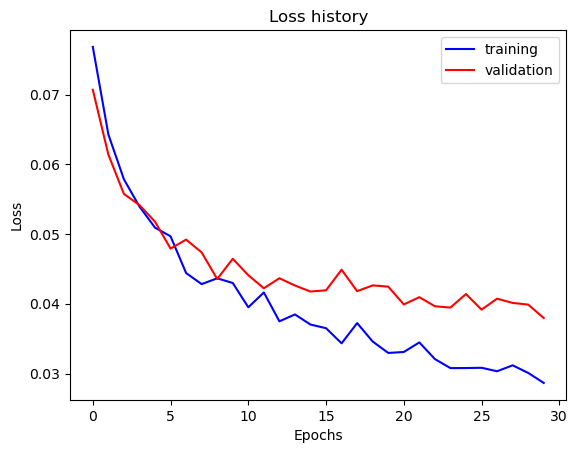

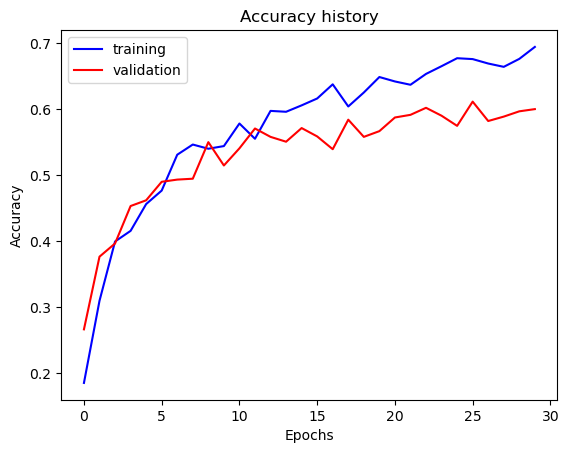

In [88]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [89]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.6941373534338359; Validation Accuracy = 0.6


**TODO 13:** Obtain a **55%** validation accuracy to receive full credit for Part 2.

### Save the model for your SimpleNetFinal

In [90]:
save_trained_model_weights(simple_model_final, out_dir="./")

### Part 2.6: Analysis using confusion matrix
A confusion matrix is a helpful tool for visualizing the performance of classification algorithms. Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class. The confusion matrix counts the number of instances of a given (target, prediction) pair. We are able to use this to understand the classification behaviour.

A confusion matrix can also be normalized by dividing each row by the total number of instances of the target class. This is helpful for comparing between large and small datasets, as well as when there is significant class imbalance.

**TODO 14:** Do the following to visualize the confusion matrix:

1. Implement the code to extract the predictions and targets from a model and a dataset
2. Implement the code to generate the confusion matrix, and its normalized form
3. Plot the confusion matrix and try to understand how your model is performing, and where it falls short. We'll use this later on for the report.

In [42]:
print(verify(test_generate_confusion_matrix))
print(verify(test_generate_confusion_matrix_normalized))

"Correct"
"Correct"


In [43]:
%%time
targets, predictions, class_labels = generate_confusion_data(
    trainer.model, trainer.val_dataset, use_cuda=is_cuda
)

CPU times: total: 7.17 s
Wall time: 1.82 s


In [44]:
confusion_matrix = generate_confusion_matrix(targets, predictions, len(class_labels))

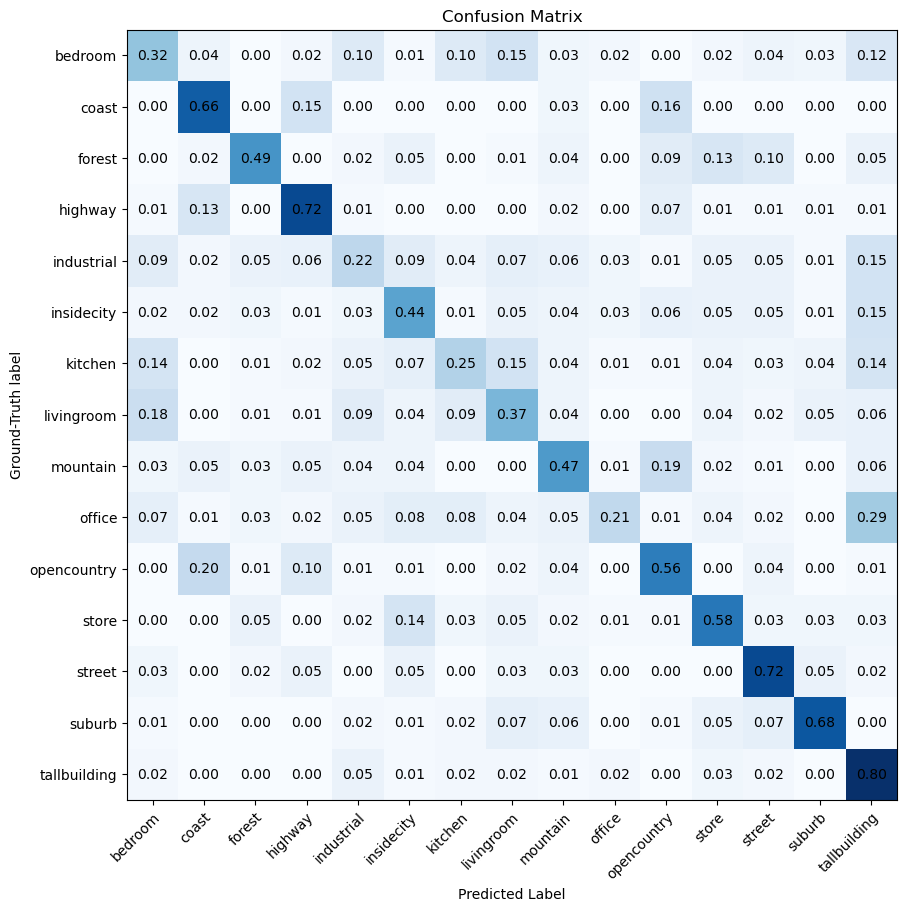

In [45]:
plot_confusion_matrix(confusion_matrix, class_labels)

## Part 3: ResNet
You can see that after the above adjustment, our model performance increases in terms of testing accuracy. Although the training accuracy drops, now it's closer to the testing values and that's more natural in terms of performance. But we are not satisfied with the final performance yet. Our model, in the end, is still a 2-layer SimpleNet and it might be capable of capturing some features, but could be improved a lot if we go **deeper**. In this part we are going to see the power of a famous model: ResNet18.

In [46]:
inp_size = (224, 224)

### Part 3.1 & 3.2: Fine-tuning the ResNet
Now let's define a ResNet which can be fit onto our dataset. PyTorch has provided us with pre-trained models like ResNet18, so what you want to do is to load the model first, and then adjust some of the layers such that it fits with our own dataset, instead of outputing scores to 1000 classes from the original ResNet18 model.


**TODO 15:** Switch to `my_resnet.py`, and copy the network architecture and weights of all but the last fc layers from the pretrained network.

After you have defined the correct architecture of the model, make some tweaks to the existing layers: **freeze** the **convolutional** layers and first 2 **linear** layers so we don't update the weights of them; more details can be found in the instruction webpage.

Note that you are allowed to add more layers/unfreeze more layers if you see fit.

In [59]:
print("Testing your ResNet architecture: ", verify(test_my_resnet))

Testing your ResNet architecture:  "Correct"


In [60]:
my_resnet = MyResNet18()
print(my_resnet)

MyResNet18(
  (fc_layers): Sequential(
    (0): Linear(in_features=512, out_features=15, bias=True)
  )
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fa

In [65]:
# TODO: add a decent initial setting and tune from there. The values are intentionally bad.
optimizer_config = {"optimizer_type": "sgd", "lr": 1.5e-2, "weight_decay": 1e-6}

In [167]:
my_resnet = MyResNet18()
optimizer = get_optimizer(my_resnet, optimizer_config)

trainer = Trainer(
    data_dir=data_path,
    model=my_resnet,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "resnet18"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
)

The following training cell will take roughly 20 minutes or slightly more using CPU (but possibly under 5 minute using GPU depending on the batch size; the TAs got it within 3 minutes on a GTX1060).

In [108]:
%%time
trainer.run_training_loop(num_epochs=5)

tensor([[[ 0.2611,  0.2611,  0.2611,  ...,  0.1371,  0.1526,  0.1991],
         [ 0.2456,  0.2611,  0.2611,  ...,  0.1371,  0.1371,  0.1526],
         [ 0.2146,  0.2611,  0.2611,  ...,  0.1991,  0.1991,  0.1836],
         ...,
         [ 0.0287,  0.1217,  0.1991,  ..., -1.3189, -1.3809, -1.2880],
         [ 0.1991,  0.1371,  0.0752,  ..., -1.3189, -1.3809, -1.2725],
         [ 0.2146,  0.1991,  0.1836,  ..., -1.3189, -1.4738, -1.2260]]])
0
tensor([[[ 1.5003,  1.5777,  1.6552,  ...,  0.1991,  0.1526,  0.1062],
         [ 1.4848,  1.5777,  1.6552,  ...,  0.2301,  0.1991,  0.1371],
         [ 1.5777,  1.6397,  1.7481,  ...,  0.2456,  0.2146,  0.1526],
         ...,
         [-1.0401, -1.0401, -1.0711,  ...,  1.6397,  1.6242,  1.5777],
         [-1.0401, -1.0401, -1.0401,  ...,  1.6087,  1.5932,  1.5468],
         [-1.0866, -1.0711, -1.0711,  ...,  1.5777,  1.5468,  1.5158]]])
0
tensor([[[-0.6838, -0.4360, -0.2811,  ..., -0.7148, -0.7148, -0.7148],
         [-0.4980, -0.3121, -0.3121,  ...

tensor([[[-1.2260, -1.5513, -1.4119,  ..., -0.4980, -0.4515, -0.2966],
         [-1.1176, -1.5358, -1.4583,  ..., -0.4825, -0.4980, -0.4515],
         [-1.0711, -1.5048, -1.4583,  ..., -0.4825, -0.5289, -0.4360],
         ...,
         [-1.5048, -1.4893, -1.4893,  ..., -0.3895, -0.7148, -0.7768],
         [-1.5203, -1.5203, -1.5048,  ..., -0.4360, -0.6374, -0.6993],
         [-1.5358, -1.5203, -1.5203,  ..., -0.5289, -0.7768, -1.0091]]])
0
tensor([[[ 0.5244,  0.6019,  0.6019,  ..., -0.0023, -0.0952, -0.0952],
         [ 0.4779,  0.5554,  0.5554,  ..., -0.0332, -0.0797, -0.0797],
         [ 0.4315,  0.5244,  0.5244,  ..., -0.0332, -0.0797, -0.0797],
         ...,
         [-0.1572, -0.2656, -0.2346,  ..., -0.5289, -0.6219, -0.5754],
         [-0.1572, -0.2656, -0.2346,  ..., -0.4980, -0.5289, -0.4670],
         [-0.1572, -0.2656, -0.2346,  ..., -0.4670, -0.4360, -0.3895]]])
0
tensor([[[1.5003, 1.3609, 1.2524,  ..., 0.6328, 0.6328, 0.6328],
         [1.5158, 1.4228, 1.2679,  ..., 0.6483,

tensor([[[-1.4893, -1.4893, -1.4893,  ..., -1.4893, -1.4893, -1.4738],
         [-1.4119, -1.4119, -1.4119,  ..., -1.4119, -1.4119, -1.4119],
         [-0.8387, -0.8387, -0.8387,  ..., -0.7148, -0.6993, -0.6993],
         ...,
         [-0.1727, -0.1727, -0.1727,  ..., -0.1417, -0.1417, -0.1417],
         [-1.2415, -1.2415, -1.2415,  ..., -1.2415, -1.2415, -1.2260],
         [-1.4738, -1.4738, -1.4738,  ..., -1.4738, -1.4583, -1.4583]]])
1
tensor([[[-1.7991, -1.7991, -1.7991,  ..., -1.7991, -1.7991, -1.7991],
         [-1.7836, -1.7836, -1.7991,  ..., -1.7991, -1.7836, -1.7527],
         [-0.2966, -0.2966, -0.3121,  ..., -0.3740, -0.3585, -0.3121],
         ...,
         [ 0.3695,  0.0287, -0.0332,  ..., -0.5289, -0.5599, -0.5599],
         [-1.4738, -1.6442, -1.6133,  ..., -1.6597, -1.7062, -1.6907],
         [-1.7991, -1.7991, -1.7991,  ..., -1.7991, -1.7991, -1.7991]]])
1
tensor([[[ 1.0975,  0.9891,  0.9891,  ...,  1.0821,  1.0821,  1.1595],
         [ 1.0201,  0.9272,  0.9272,  ...

tensor([[[ 1.0821,  1.0821,  1.0821,  ...,  1.0821,  1.0821,  1.0821],
         [ 1.0356,  1.0356,  1.0356,  ...,  1.0821,  1.0821,  1.0821],
         [ 1.0666,  1.0666,  1.0666,  ...,  1.0666,  1.0666,  1.0666],
         ...,
         [-1.4893, -1.3809, -1.0866,  ..., -1.5823, -1.6752, -1.2880],
         [-1.1176, -1.2415, -1.1176,  ..., -0.8078, -0.9007, -0.5754],
         [-1.2725, -0.9936, -0.8078,  ..., -0.7613, -0.5754, -0.6683]]])
1
tensor([[[-1.2105, -1.2105, -1.1950,  ..., -0.7458, -0.7458, -0.7148],
         [-1.1950, -1.1950, -1.1950,  ..., -0.7613, -0.7458, -0.7458],
         [-1.1795, -1.1795, -1.1950,  ..., -0.7613, -0.7458, -0.7458],
         ...,
         [-1.5358, -1.5358, -1.5358,  ..., -1.4429, -1.4274, -1.3809],
         [-1.5513, -1.5358, -1.5203,  ..., -1.4429, -1.4429, -1.3964],
         [-1.5203, -1.5048, -1.5048,  ..., -1.4274, -1.4274, -1.3809]]])
1
tensor([[[-1.1331, -1.1331, -1.1176,  ...,  0.3540,  0.3385,  0.3385],
         [-1.1485, -1.1331, -1.1176,  ...

tensor([[[-1.7991, -1.5358, -1.6287,  ..., -1.7372, -1.7372, -1.7527],
         [-1.3344,  0.0287,  0.1062,  ..., -0.4360, -0.4515, -0.4515],
         [-1.1331,  1.0975,  1.1285,  ...,  0.2766,  0.2766,  0.2766],
         ...,
         [-1.7991, -1.3344, -1.3344,  ..., -0.9627, -0.9627, -1.0091],
         [-1.7836, -1.2260, -1.3809,  ..., -0.9627, -0.9317, -0.9472],
         [-1.7836, -1.4429, -1.5203,  ..., -1.0556, -0.9472, -0.9317]]])
1
tensor([[[ 0.1371,  0.1371,  0.1526,  ...,  0.6019,  0.6173,  0.6483],
         [ 0.1681,  0.1681,  0.1681,  ...,  0.6173,  0.6173,  0.6638],
         [ 0.1836,  0.1836,  0.1836,  ...,  0.6173,  0.6483,  0.6638],
         ...,
         [-1.3499, -1.3964, -1.3654,  ..., -0.3585, -0.1727, -0.0642],
         [-1.3034, -1.2880, -1.2105,  ..., -0.3740, -0.2036, -0.0332],
         [-1.2880, -1.3034, -1.2880,  ..., -0.9936, -0.9162, -0.7613]]])
1
tensor([[[ 0.8652,  0.8962,  0.8962,  ...,  0.6793,  0.6948,  0.6948],
         [ 0.8652,  0.8807,  0.8962,  ...

tensor([[[-0.2191, -0.2191, -0.2036,  ...,  1.2989,  1.2989,  1.2989],
         [-0.2036, -0.1881, -0.1727,  ...,  1.2989,  1.2989,  1.2989],
         [-0.1881, -0.1727, -0.1572,  ...,  1.2989,  1.2989,  1.2989],
         ...,
         [-1.3034, -1.2260, -1.1485,  ...,  0.4160,  0.3075,  0.6019],
         [-1.0866, -1.0091, -0.9317,  ...,  1.0666,  0.8497,  0.8342],
         [-1.2415, -1.2415, -1.2415,  ..., -0.6838, -0.6993, -0.5909]]])
1
tensor([[[ 1.2370,  1.2370,  1.2370,  ...,  1.8256,  1.8256,  1.8256],
         [ 1.1440,  1.1440,  1.1440,  ...,  1.7636,  1.7172,  1.7017],
         [ 1.0666,  1.0821,  1.0821,  ...,  1.7172,  1.6552,  1.6242],
         ...,
         [-1.0866, -1.0866, -1.1021,  ..., -1.0866, -1.0866, -1.0866],
         [-1.0866, -1.0866, -1.1021,  ..., -1.0866, -1.0866, -1.0866],
         [-1.0866, -1.1021, -1.1021,  ..., -1.0866, -1.0866, -1.0711]]])
1
tensor([[[-0.5599, -0.5599, -0.5444,  ..., -0.6838, -0.6838, -0.6838],
         [-0.5599, -0.5599, -0.5444,  ...

tensor([[[ 0.9426,  0.3075, -0.0023,  ...,  0.5709,  0.6019,  0.5399],
         [-0.0487, -0.0178, -0.1727,  ...,  0.4624,  0.6328,  0.4779],
         [-0.0487,  0.1062,  0.1371,  ...,  0.4934,  0.6328,  0.4624],
         ...,
         [-0.7303, -0.7458, -0.0178,  ...,  1.1750,  1.5623,  1.4538],
         [-0.3121,  0.1062, -0.2656,  ...,  1.2679,  1.4383,  1.8101],
         [-0.5599, -1.1485, -0.9007,  ...,  1.4383,  1.5932,  1.9030]]])
2
tensor([[[ 0.8187,  0.3540, -0.1262,  ...,  0.1836,  0.1062,  0.1991],
         [ 0.8962,  0.2921, -0.1881,  ...,  0.1836,  0.1681,  0.2456],
         [ 0.4160, -0.0952, -0.2811,  ...,  0.2766,  0.1681,  0.1991],
         ...,
         [ 0.9736,  1.0511,  1.0356,  ..., -0.3585, -0.4825, -0.5754],
         [ 0.9272,  1.1905,  1.2989,  ..., -0.4515, -0.5134, -0.3430],
         [ 0.7258,  1.0511,  1.1905,  ..., -0.3276, -0.4825, -0.2501]]])
2
tensor([[[ 0.9736,  0.7413,  0.7723,  ...,  0.2146,  0.8807,  1.9805],
         [ 0.7723,  0.5399,  0.6948,  ...

tensor([[[-0.6993, -1.3964, -1.7991,  ..., -1.7991, -1.7991, -1.7991],
         [-0.4515, -1.5358, -1.5358,  ..., -1.7682, -1.7991, -1.7991],
         [-0.7148, -1.6133, -1.6133,  ..., -1.7991, -1.7991, -1.7991],
         ...,
         [-0.9162, -0.5909, -0.3895,  ..., -1.7991, -1.7991, -1.7991],
         [-0.8852, -0.1727, -0.0023,  ..., -1.7991, -1.7991, -1.7991],
         [-1.3189, -0.3895, -0.0797,  ..., -1.7991, -1.7991, -1.7991]]])
2
tensor([[[-1.5513, -1.1640, -0.0797,  ..., -0.2811, -0.5289, -0.3430],
         [-0.5754, -0.2656,  0.6328,  ..., -0.0178,  0.2301, -0.2656],
         [ 0.4470,  0.1836,  0.2301,  ..., -0.0952, -0.0178,  0.1371],
         ...,
         [ 0.8342,  0.7568,  0.5554,  ...,  0.2921,  0.1836,  0.1991],
         [ 0.9117,  0.6638,  0.5709,  ...,  0.2766,  0.1526,  0.1371],
         [ 0.7877,  0.6483,  0.8032,  ...,  0.1836,  0.0752,  0.0287]]])
2
tensor([[[ 1.3454,  1.9340,  1.8101,  ...,  1.7946,  1.9185,  1.3454],
         [ 1.9185,  2.1509,  2.1509,  ...

tensor([[[ 2.1509,  1.0046, -1.0246,  ..., -0.5289, -0.3276, -0.6219],
         [ 0.2766,  2.0579, -0.1881,  ..., -0.7458, -0.5909, -0.4980],
         [-0.4205,  1.6552,  0.5554,  ..., -0.5909, -0.8852, -1.1021],
         ...,
         [ 2.1509,  2.1509,  2.1509,  ..., -0.0178,  0.5864,  0.6173],
         [ 2.1509,  2.1509,  2.1509,  ..., -0.5444, -0.0332,  0.0597],
         [ 2.1509,  2.1509,  2.1509,  ..., -0.7768, -0.4980, -0.4515]]])
2
tensor([[[-1.2415, -1.0866, -1.1950,  ..., -0.5289, -0.9162, -1.0091],
         [-0.9782, -1.0556, -1.1485,  ..., -0.7148, -1.0246, -1.1331],
         [-0.7458, -0.9627, -0.9472,  ..., -0.6529, -0.7303, -0.7768],
         ...,
         [-0.9627, -0.7613, -0.6529,  ..., -1.4119, -1.5048, -1.2880],
         [-0.2656, -0.0642, -0.2501,  ..., -1.1950, -1.5668, -1.3964],
         [-0.4515,  0.0597, -0.2346,  ..., -0.7768, -0.9936, -1.1331]]])
2
tensor([[[ 0.8652,  1.0511,  0.6793,  ..., -1.0246, -0.8387, -0.4670],
         [ 0.6638,  0.4624, -0.1417,  ...

tensor([[[-1.4274, -1.6287, -1.6442,  ..., -1.7991, -1.5358, -1.6907],
         [-1.2260, -1.3499, -1.4893,  ..., -1.7991, -1.7372, -1.7217],
         [-1.3964, -1.5203, -1.6907,  ..., -1.7991, -1.7991, -1.7217],
         ...,
         [-1.7991, -1.7991, -1.7991,  ..., -1.7682, -1.7372, -1.7991],
         [-1.7991, -1.7991, -1.7991,  ..., -1.7372, -1.6907, -1.5048],
         [-1.7836, -1.7991, -1.7991,  ..., -1.5978, -1.3809, -0.9782]]])
2
tensor([[[-1.1485, -1.3034, -1.4583,  ..., -1.3499, -1.3344, -1.2725],
         [-1.2880, -1.3809, -1.4893,  ..., -1.1021, -1.1331, -1.0556],
         [-1.4583, -1.5513, -1.6287,  ..., -0.9007, -0.9472, -0.9162],
         ...,
         [-1.7991, -1.7991, -1.7991,  ..., -1.7217, -1.7682, -1.7217],
         [-1.7991, -1.7991, -1.7991,  ..., -1.5823, -1.7217, -1.7991],
         [-1.7991, -1.7991, -1.7991,  ..., -1.5048, -1.5978, -1.6597]]])
2
tensor([[[ 1.8566,  1.5468,  2.1509,  ..., -0.5289, -0.5289, -0.5289],
         [ 1.4228,  1.3454,  2.1509,  ...

tensor([[[ 0.2611,  0.5864,  0.4470,  ...,  1.0201,  1.1285,  0.8187],
         [ 0.6638,  0.9426,  0.8187,  ...,  1.2834,  1.4228,  1.0821],
         [ 0.7258,  1.0046,  0.8187,  ...,  1.0666,  1.1905,  0.8497],
         ...,
         [-0.3585, -0.1881, -0.2501,  ..., -0.1572, -0.0023, -0.2346],
         [-0.3276, -0.1572, -0.2656,  ..., -0.0952,  0.0752, -0.1572],
         [-0.4825, -0.3430, -0.4980,  ..., -0.2191, -0.0332, -0.3121]]])
3
tensor([[[-0.3430, -0.2191, -0.2656,  ..., -0.4205, -0.3895, -0.4670],
         [-0.2036, -0.0797, -0.1262,  ..., -0.3430, -0.2966, -0.3895],
         [-0.2656, -0.1572, -0.1881,  ..., -0.3895, -0.3430, -0.4205],
         ...,
         [-0.7303, -0.6993, -0.6993,  ..., -0.6529, -0.5909, -0.6993],
         [-0.7303, -0.6838, -0.6838,  ..., -0.5289, -0.4670, -0.5754],
         [-0.7768, -0.7303, -0.7303,  ..., -0.5289, -0.4980, -0.6219]]])
3
tensor([[[-0.6993, -0.5134, -0.5754,  ..., -0.6064, -0.5599, -0.7613],
         [-0.5134, -0.3121, -0.3740,  ...

tensor([[[-0.0487, -0.0487, -0.0487,  ..., -0.1107, -0.1107, -0.1107],
         [-0.0487, -0.0487, -0.0487,  ..., -0.1107, -0.1107, -0.1107],
         [-0.0487, -0.0487, -0.0487,  ..., -0.1107, -0.1107, -0.1107],
         ...,
         [-0.5599, -0.5444, -0.5289,  ..., -0.3430, -0.3276, -0.3430],
         [-0.5289, -0.5599, -0.5599,  ..., -0.3585, -0.3430, -0.3430],
         [-0.5289, -0.5599, -0.5909,  ..., -0.3895, -0.3430, -0.3430]]])
3
tensor([[[1.2989, 1.2989, 1.2989,  ..., 0.8807, 0.8807, 0.8807],
         [1.2989, 1.2989, 1.2989,  ..., 0.8807, 0.8807, 0.8807],
         [1.2989, 1.2989, 1.2989,  ..., 0.8807, 0.8807, 0.8807],
         ...,
         [0.7103, 0.6483, 0.5864,  ..., 0.8652, 0.8342, 0.6483],
         [0.6328, 0.6173, 0.5709,  ..., 0.7413, 0.7103, 0.5399],
         [0.5864, 0.6328, 0.6328,  ..., 0.5709, 0.6638, 0.6483]]])
3
tensor([[[0.4005, 0.4005, 0.4005,  ..., 0.4470, 0.4470, 0.4470],
         [0.4005, 0.4005, 0.4005,  ..., 0.4470, 0.4470, 0.4470],
         [0.4005, 

tensor([[[ 1.5003,  1.5158,  1.5158,  ...,  1.2215,  1.2215,  1.2215],
         [ 1.4538,  1.4848,  1.5003,  ...,  1.2215,  1.2215,  1.2215],
         [ 1.4538,  1.4848,  1.4848,  ...,  1.2370,  1.2370,  1.2370],
         ...,
         [ 1.7017,  1.7326,  1.7481,  ..., -0.6993, -0.7303, -0.6993],
         [ 1.7326,  1.7481,  1.7636,  ..., -0.6993, -0.6993, -0.6838],
         [ 1.7481,  1.7636,  1.7636,  ..., -0.6838, -0.6993, -0.7148]]])
3
tensor([[[ 1.7172,  1.7172,  1.7172,  ...,  1.3919,  1.3919,  1.3919],
         [ 1.7172,  1.7172,  1.7172,  ...,  1.3919,  1.3919,  1.3919],
         [ 1.7172,  1.7172,  1.7172,  ...,  1.3919,  1.3919,  1.3919],
         ...,
         [ 0.0132,  0.0132,  0.0132,  ..., -0.2966, -0.2966, -0.3121],
         [ 0.0132,  0.0132,  0.0132,  ..., -0.2966, -0.2966, -0.3121],
         [ 0.0132,  0.0132,  0.0132,  ..., -0.2966, -0.2966, -0.3121]]])
3
tensor([[[ 0.1991,  0.2146,  0.2146,  ..., -0.0178, -0.0332, -0.0487],
         [ 0.1991,  0.2146,  0.2301,  ...

tensor([[[-1.4429, -1.3964, -1.3654,  ..., -0.9627, -0.9627, -0.9782],
         [-1.3964, -1.4119, -1.3964,  ..., -0.9472, -0.9472, -1.0246],
         [-1.3344, -1.3499, -1.3964,  ..., -1.1331, -1.2260, -1.3034],
         ...,
         [-0.8078, -0.8387, -0.8542,  ..., -1.3344, -1.3034, -1.3034],
         [-0.9007, -0.9162, -0.9007,  ..., -1.1950, -1.1485, -1.1331],
         [-0.9007, -0.9007, -0.8697,  ..., -1.0556, -1.0556, -1.1021]]])
4
tensor([[[ 0.6173,  0.6328,  0.6483,  ...,  0.7413,  0.7258,  0.7258],
         [ 0.6638,  0.6638,  0.6638,  ...,  0.7568,  0.7413,  0.7258],
         [ 0.6483,  0.6638,  0.6638,  ...,  0.7877,  0.7723,  0.7413],
         ...,
         [-0.9317, -0.8697, -0.8697,  ..., -1.0711, -1.0711, -1.0246],
         [-0.9007, -0.8697, -0.8852,  ..., -1.0556, -1.0711, -1.0711],
         [-0.8852, -0.9317, -0.9472,  ..., -1.0091, -0.9782, -0.9627]]])
4
tensor([[[ 1.7946,  2.0425,  2.0425,  ...,  2.0425,  2.0425,  2.0425],
         [ 1.8876,  2.0425,  2.0425,  ...


KeyboardInterrupt



Like both previous sections, you are required to pass a threshold of **85%** for this part. Copy the plots and values onto the report and answer questions accordingly.

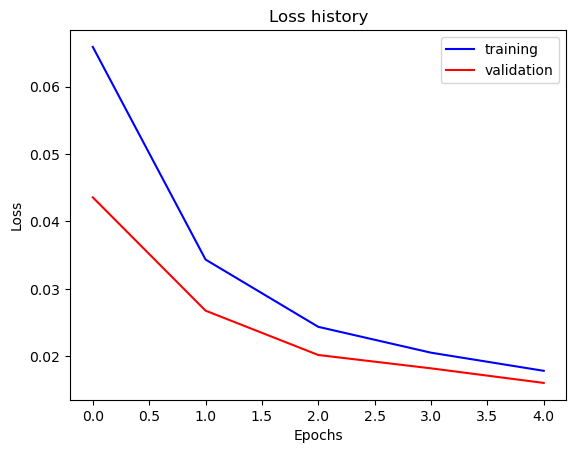

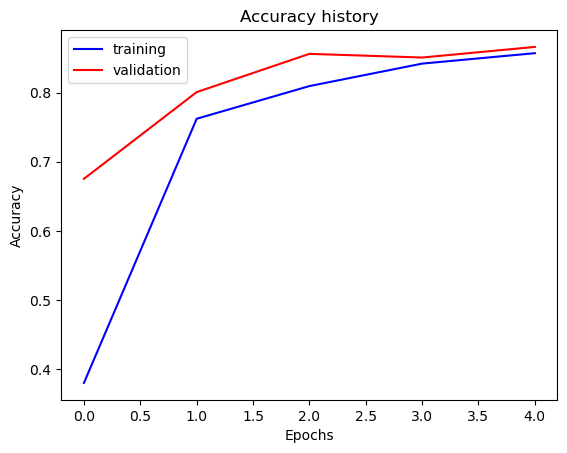

In [68]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [69]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.8569514237855946; Validation Accuracy = 0.866


**TODO 16**: Obtain a **85%** validation accuracy to receive full credits for Part 3.

### Save Trained MyResnet18 model

In [73]:
save_trained_model_weights(my_resnet, out_dir="./")

### Part 3.3 Visualize and Analyze Confusion Matrix

**TODO 17:** Visualize and analyze the confusion matrix.

You'll need to find an example of an image that is misclassified for the report. Use the confusion matrix and the `get_pred_images_for_target` function to help your analysis

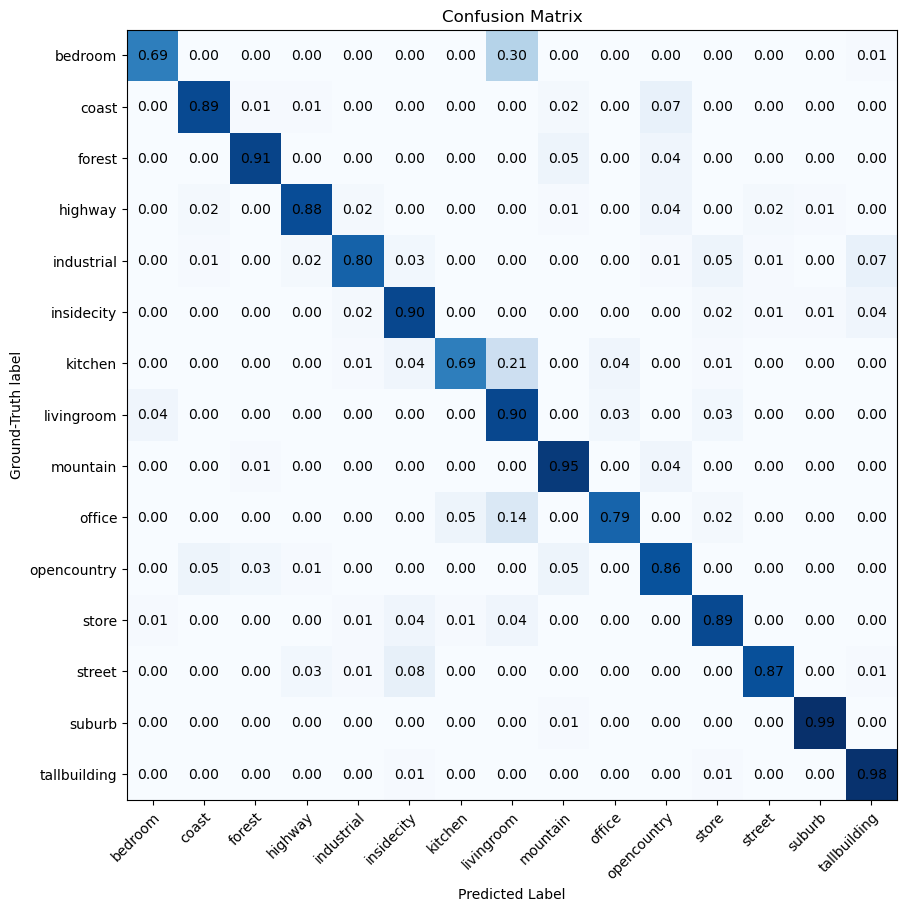

In [71]:
generate_and_plot_confusion_matrix(my_resnet, trainer.val_dataset, use_cuda=is_cuda)

In [72]:
#########################
# Use this cell to visualize your images depending on the confusion matrix visualization
#########################

# Part 4: Multilabel Classification - Scene Attribute Prediction (Extra Credit for Undergrads)

Thus far, our convolutional neural network models are able to classify the class of the input image. This part of the project is focused on training a model that is capable of predicting attributes in images.

A subset of the above dataset containing images only from the 'coast', 'highway', 'mountain', 'opencountry', 'street' classes will be used. Target labels are represented as binary arrays corresponding to the following attributes:
<ul>
    <li> Clouds </li>
    <li> Water body </li>
    <li> People </li>
    <li> Animals </li>
    <li> Natural </li>
    <li> Man-made </li>
    <li> Vehicles </li>
</ul>

For example, if an input image of a natural scene has clouds, people and vehicles only, we expect an output of [1, 0, 1, 0, 1, 0, 1].

## Part 4.1 & 4.2 Model Architecture & Training
**TODO 18:** Switch to `multilabel_resnet.py`, and copy the network architecture and weights of all but the last fc layers from the pretrained network. Modify the network to obtain the desired output as shown above.

After you have defined the correct architecture of the model, make some tweaks to the existing layers: **freeze** the **convolutional** layers and first 2 **linear** layers so we don't update the weights of them; more details can be found in the instruction webpage.

Note that you are allowed to add more layers/unfreeze more layers if you see fit.

In [149]:
print("Testing your multilabel image loader (length):", verify(test_multilabel_dataset_length))
print("Testing your multilabel image loader (values):", verify(test_multilabel_unique_vals))

Testing your multilabel image loader (length): "Correct"
Testing your multilabel image loader (values): "Correct"


In [150]:
print("Testing your MultilabelResNet architecture: ", verify(test_multilabel_resnet))

Testing your MultilabelResNet architecture:  "Correct"


In [151]:
multi_resnet = MultilabelResNet18()
print(multi_resnet)

MultilabelResNet18(
  (activation): Sigmoid()
  (fc_layers): Sequential(
    (0): Linear(in_features=512, out_features=7, bias=True)
  )
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), strid

In [152]:
inp_size = (224, 224)

In [177]:
# TODO: add a decent initial setting and tune from there. The values are intentionally bad.
optimizer_config = {"optimizer_type": "sgd", "lr": 10e-2, "weight_decay": 1e-6}

In [178]:
multi_resnet = MultilabelResNet18()
optimizer = get_optimizer(multi_resnet, optimizer_config)

trainer = MultiLabelTrainer(
    data_dir=data_path,
    model=multi_resnet,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "multilabel_resnet18"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
)

In [179]:
%%time
trainer.run_training_loop(num_epochs=5)

Epoch:1 Train Loss:0.0168 Val Loss: 0.0128 Train Accuracy: 0.7329 Validation Accuracy: 0.8497
Epoch:2 Train Loss:0.0109 Val Loss: 0.0097 Train Accuracy: 0.8661 Validation Accuracy: 0.8886
Epoch:3 Train Loss:0.0091 Val Loss: 0.0088 Train Accuracy: 0.8883 Validation Accuracy: 0.9006
Epoch:4 Train Loss:0.0086 Val Loss: 0.0085 Train Accuracy: 0.8969 Validation Accuracy: 0.9037
Epoch:5 Train Loss:0.0081 Val Loss: 0.0082 Train Accuracy: 0.9042 Validation Accuracy: 0.9043
CPU times: total: 25min 31s
Wall time: 6min 30s


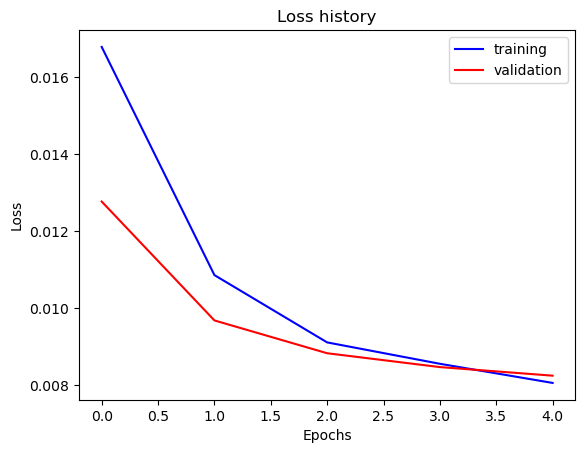

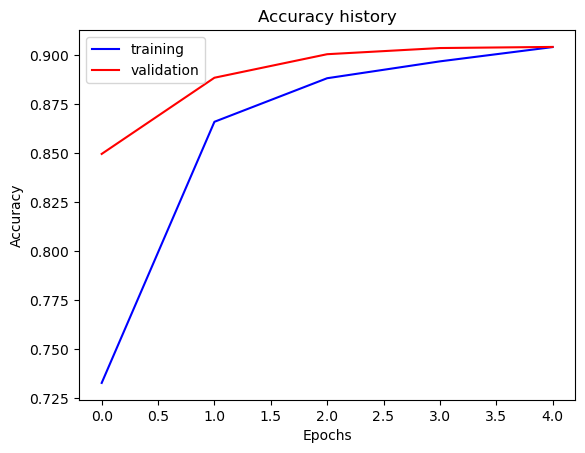

In [180]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [181]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.9042044911610129; Validation Accuracy = 0.9042857142857142


**TODO 19**: Obtain a **90%** validation accuracy to receive full credits for Part 4.

### Save Trained MultilabelResnet18 model

In [182]:
save_trained_model_weights(multi_resnet, out_dir="./")

## 4.3 Visualize Results

Having an overall accuracy of above 90% does not necessarily mean that the model is performing well. To truly analyze its performance in this multi-label classification task, the accuracy of each attribute should also be considered.

**TODO 20**: Complete the accuracy table for your multi-label classification model. 

In [183]:
print("Testing your multilabel accuracy table:", verify(test_compute_multilabel_accuracy))

Testing your multilabel accuracy table: "Correct"


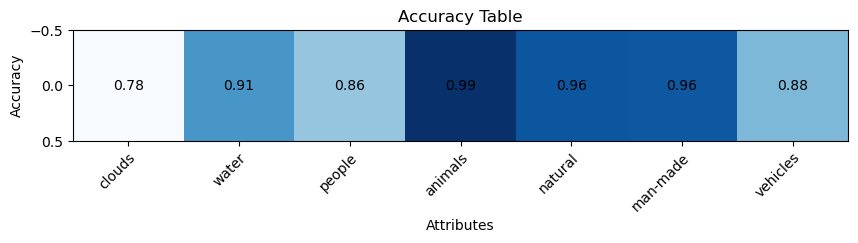

In [184]:
att_list = ['clouds', 'water', 'people', 'animals', 'natural', 'man-made', 'vehicles']

generate_and_plot_accuracy_table(
    multi_resnet, 
    trainer.val_dataset, 
    num_attributes=7,
    attribute_labels=att_list,
    use_cuda=is_cuda
)